In [1]:
!pip -q install tensorflow-io

     |████████████████████████████████| 24.1MB 126kB/s 
     |████████████████████████████████| 2.5MB 33.7MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds

In [3]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=False
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256

# RGB Color Space

In [5]:
@tf.function
def preprocess_rgb(data):
    image = tf.image.convert_image_dtype(data['image'], tf.float32)
    image = tf.image.resize(image, (224, 224))
    return image

In [6]:
training_ds_rgb = (
    train_ds
    .map(preprocess_rgb, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [7]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

(256, 224, 224, 3)


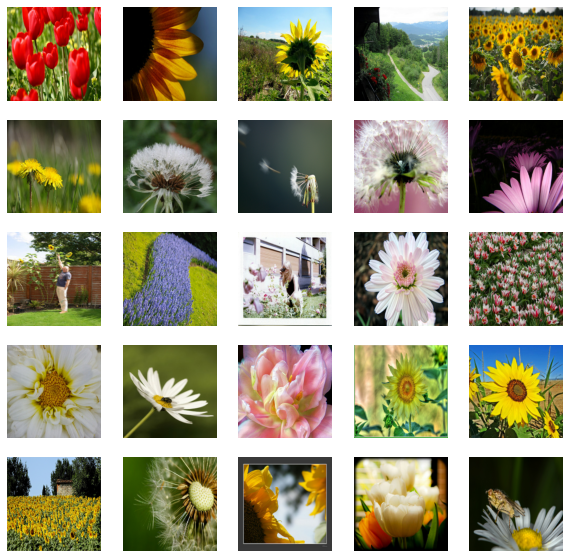

In [8]:
image_batch = next(iter(training_ds_rgb))
print(image_batch.shape)

show_batch(image_batch)

In [9]:
print("IMAGE BATCH")
print(f"  [SHAPE]: {image_batch.shape}")
print(f"  [MIN]:{tf.math.reduce_min(image_batch)}")
print(f"  [MEAN]:{tf.math.reduce_mean(image_batch)}")
print(f"  [MAX]:{tf.math.reduce_max(image_batch)}")

IMAGE BATCH
  [SHAPE]: (256, 224, 224, 3)
  [MIN]:0.0
  [MEAN]:0.41168177127838135
  [MAX]:1.0


# LAB color space

In [47]:
@tf.function
def preprocess_lab(data):
    image = tf.cast(data['image']/255, tf.float32)
    image = tf.image.resize(image, (224, 224))
    lab = tfio.experimental.color.rgb_to_lab(image)
    l = lab[...,0]/50.0 - 1.0
    a = lab[...,1]/110.0
    b = lab[...,2]/110.0
    
    l = tf.expand_dims(l, axis=-1)
    a = tf.expand_dims(a, axis=-1)
    b = tf.expand_dims(b, axis=-1)

    lab = tf.concat([l,a,b], axis=-1)
    return lab

In [48]:
training_ds_lab = (
    train_ds
    .map(preprocess_lab, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

lab_batch = next(iter(training_ds_lab))

In [52]:
l = lab_batch[..., 0, None]
a = lab_batch[..., 1, None]
b = lab_batch[..., 2, None]

print("L")
print(f"  [SHAPE]: {l.shape}")
print(f"  [MIN]:{tf.math.reduce_min(l)}")
print(f"  [MEAN]:{tf.math.reduce_mean(l)}")
print(f"  [MAX]:{tf.math.reduce_max(l)}")

print("a")
print(f"  [SHAPE]: {a.shape}")
print(f"  [MIN]:{tf.math.reduce_min(a)}")
print(f"  [MEAN]:{tf.math.reduce_mean(a)}")
print(f"  [MAX]:{tf.math.reduce_max(a)}")

print("b")
print(f"  [SHAPE]: {b.shape}")
print(f"  [MIN]:{tf.math.reduce_min(b)}")
print(f"  [MEAN]:{tf.math.reduce_mean(b)}")
print(f"  [MAX]:{tf.math.reduce_max(b)}")

L
  [SHAPE]: (256, 224, 224, 1)
  [MIN]:-1.0
  [MEAN]:-0.06168659031391144
  [MAX]:1.0
a
  [SHAPE]: (256, 224, 224, 1)
  [MIN]:-0.6423406004905701
  [MEAN]:0.00909004919230938
  [MAX]:0.8334671854972839
b
  [SHAPE]: (256, 224, 224, 1)
  [MIN]:-0.9322031140327454
  [MEAN]:0.1463838666677475
  [MAX]:0.8588921427726746


Conversion from Lab to RGB

In [53]:
@tf.function
def lab_rgb(lab):
    l = lab[..., 0, None]
    a = lab[..., 1, None]
    b = lab[..., 2, None]

    l = (l + 1.0)* 50.0
    a = a * 110.0
    b = b * 110.0

    lab = tf.concat([l,a,b], axis=-1)
    rgb = tfio.experimental.color.lab_to_rgb(lab)
    return rgb

In [54]:
lab_ds = (
    train_ds
    .map(preprocess_lab)
)

rgb_ds = (
    lab_ds
    .map(lab_rgb, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [55]:
rgb_batch = next(iter(rgb_ds))

In [56]:
print("IMAGE BATCH")
print(f"  [SHAPE]: {rgb_batch.shape}")
print(f"  [MIN]:{tf.math.reduce_min(rgb_batch)}")
print(f"  [MEAN]:{tf.math.reduce_mean(rgb_batch)}")
print(f"  [MAX]:{tf.math.reduce_max(rgb_batch)}")

IMAGE BATCH
  [SHAPE]: (256, 224, 224, 3)
  [MIN]:0.0
  [MEAN]:0.41168177127838135
  [MAX]:1.0


In [57]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

(256, 224, 224, 3)


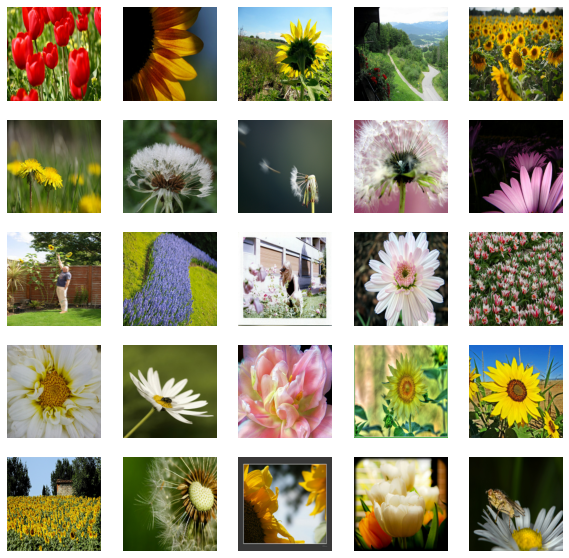

In [59]:
print(rgb_batch.shape)

show_batch(rgb_batch)